## Using Data to Support Microsoft's Original Video Content Venture

* Student name: Jacqueline Du Bois 
* Student pace: Self paced (Flex)
* Instructor name: Mark Barbour


## Overview

This project analyzes available movie data to help Microsoft decide which movie genres might offer the most successful entry into the original content video production market and who they could hire as a director to assist the production.

## Business Problem

Microsoft is entertaining the prospects of a new business venture to create original video content.  This is the company's first foray into movie production, therefore to help Microsoft to decide how to allocate its available resources, I first identify a method of looking across available measures of popularity, quality, and local market profitability to determine what makes for a successful movie.  Upon assembling a set of successful movies using these criteria, I solve the following research questions:
1. Are there particular genres of films that appears frequently within the list of successful movies?
2. Are there directors that are more likely than others to be associated with films in this list?
3. Of the directors who have produced several succesful movies, who would be best equipped to work collaboratively with Microsoft to design a project?

The answers to these questions will define two alternatives Microsoft can choose between to enter the market: either selecting a genre and the best director to direct it, or choosing the most successful director and granting him or her the freedom to work with Microsoft to select the most appropriate subject matter.   

## Data Understanding

The following publicly available data are used:
* An "IMDb" database containing tables pertaining to basic movie characteristics, ratings, and principle production members.

The IMDb database is valuable in that it permits the matching of movies to their ratings and facilitating insights into whether specific genres are correlated with higher ratings.  Likewise, it permits inquiry into the influence of directors, actors, and writers on movie success.  IMDb counts itself as "the world's most popular and authoritative source" for visual media information.<sup>1</sup>  

* Movie budget data provided by "The Numbers" which in addition to the production budget lists the domestic and global profits for each movies.

The merit of "The Numbers" data is that it allows for insight into the return on investment of a movie.  Looking solely at profits may obscure the fact that a movie actually lost money or was dependent on global viewing to break even.  "The Numbers" is one of the largest freely-available sources of movie industry information.<sup>2</sup>


1. "IMDB Help Center," IMDb, accessed April 8, 2023, https://help.imdb.com/article/imdb/general-information/what-is-imdb/G836CY29Z4SGNMK5?ref_=helpsect_cons_1_1#. 
2. "History," The Numbers, accessed April 8, 2023, https://www.the-numbers.com/about-us. 

### Assumptions
1. The study is limited to movies that have already been to the box office. Movies yet to debut are eliminated.
2. Ratings are subject to selection bias wherein critics with a strong liking or strong aversion to a movie are more likely to submit a rating.  Movies with high numbers of ratings are considered more likely to have been seen and thus more popular.
3. Quality of a film is measured by the ratings received for a given movie.
4. Movies that feature multiple terms to define the genre are best described by the first of those terms. 
5. The movie production budget refers only to the monies required to produce the film and do not include marketing.
6. If a movie was able to generate a profit locally, it is deemed financially successful.
7. Monetary amounts are assumed to be in constant dollars to facilitate comparisons between movies made in different years.
8. The director plays a pivotal role in the success of a movie.
9. When more than one director participates on a film, the one who has a lower "order" number in the imdb "principals" table is considered the primary director.
10. A successful movie is determined as having popularity (number of votes), quality (ratings), and profitability (net domestic profits) above the average for all movies assessed.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### IMDB Database Tables

Movie Basics, Ratings, Principals, and Persons tables

In [3]:
# Unzip IMDb database file
! unzip zippedData/im.db.zip

Archive:  zippedData/im.db.zip
  inflating: im.db                   


In [2]:
# Establish connection to the database file and confirm table schema
conn = sqlite3.connect('im.db')
schema_imdb = pd.read_sql("""SELECT * 
                               FROM sqlite_master
                              WHERE type = 'table';
                          """, conn)

print(schema_imdb['sql'][0])
print(schema_imdb['sql'][4])
print(schema_imdb['sql'][5])
print(schema_imdb['sql'][6])

CREATE TABLE "movie_basics" (
"movie_id" TEXT,
  "primary_title" TEXT,
  "original_title" TEXT,
  "start_year" INTEGER,
  "runtime_minutes" REAL,
  "genres" TEXT
)
CREATE TABLE "movie_ratings" (
"movie_id" TEXT,
  "averagerating" REAL,
  "numvotes" INTEGER
)
CREATE TABLE "persons" (
"person_id" TEXT,
  "primary_name" TEXT,
  "birth_year" REAL,
  "death_year" REAL,
  "primary_profession" TEXT
)
CREATE TABLE "principals" (
"movie_id" TEXT,
  "ordering" INTEGER,
  "person_id" TEXT,
  "category" TEXT,
  "job" TEXT,
  "characters" TEXT
)


In [3]:
#Characterizing the IMDb "movie_basics" table
imdb_movie_basics = pd.read_sql("""SELECT *
                                    FROM movie_basics;
                                """, conn)

#Confirm data types and missing values
print(imdb_movie_basics.info(),'\n')

#Find descriptive statistics for quantitative values
print(imdb_movie_basics.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB
None 

          start_year  runtime_minutes
count  146144.000000    114405.000000
mean     2014.621798        86.187247
std         2.733583       166.360590
min      2010.000000         1.000000
25%      2012.000000        70.000000
50%      2015.000000        87.000000
75%      2017.000000        99.000000
max      2115.000000     51420.000000


In [4]:
#Characterizing the IMDb "movie_ratings" table
imdb_movie_rate = pd.read_sql("""SELECT *
                                    FROM movie_ratings;
                                """, conn)

#Confirm data types and missing values
print(imdb_movie_rate.info(),'\n')

#Find descriptive statistics for quantitative values
print(imdb_movie_rate.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB
None 

       averagerating      numvotes
count   73856.000000  7.385600e+04
mean        6.332729  3.523662e+03
std         1.474978  3.029402e+04
min         1.000000  5.000000e+00
25%         5.500000  1.400000e+01
50%         6.500000  4.900000e+01
75%         7.400000  2.820000e+02
max        10.000000  1.841066e+06


In [5]:
#Characterizing the IMDB "principals" table
imdb_principals = pd.read_sql("""SELECT *
                                   FROM principals;
                              """, conn)

#Confirm data types and missing values
print(imdb_principals.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB
None


In [6]:
#Characterizing the IMDB "persons" table
imdb_persons = pd.read_sql("""SELECT *
                                FROM persons;
                              """, conn)

#Confirm data types and missing values
print(imdb_persons.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB
None


### "The Numbers" 
Movie Production Budget and Gross Earnings Data

In [7]:
budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

#View data items and summary of years contained
print(budget.info(),'\n')
print(budget.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB
None 

                id
count  5782.000000
mean     50.372363
std      28.821076
min       1.000000
25%      25.000000
50%      50.000000
75%      75.000000
max     100.000000


## Data Preparation

The data preparation step requires first joining the full set of movies represented in the movie_basics table with the movie ratings stored on the movie_ratings table and restricting the year of airing to before 2023.  I exclude any movies missing from either file by performing an inner join.

In [8]:
#Introduce and join ratings data to movie_basics data
imdb_basics_ratings = pd.read_sql("""SELECT mb.movie_id, 
                                            mb.primary_title, 
                                            mb.start_year, 
                                            mb.genres, 
                                            mr.averagerating AS avg_rating,
                                            mr.numvotes
                                       FROM movie_basics AS mb
                                      INNER JOIN movie_ratings AS mr
                                            ON mb.movie_id = mr.movie_id
                                      WHERE mb.start_year < 2023
                                      ORDER BY mr.averagerating DESC;
                                    """, conn)
imdb_basics_ratings.head(10)
imdb_basics_ratings.info()  #73856 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   primary_title  73856 non-null  object 
 2   start_year     73856 non-null  int64  
 3   genres         73052 non-null  object 
 4   avg_rating     73856 non-null  float64
 5   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.4+ MB


To determine whether the number of votes and average rating can be looked at as independent measures, the Pearson correlation coefficient is computed.  Here it is positive but extremely small suggesting these two measures of number of votes (popularity) and rating (quality) are independent and can be looked at as measuring different aspects of an audience's response to a film.

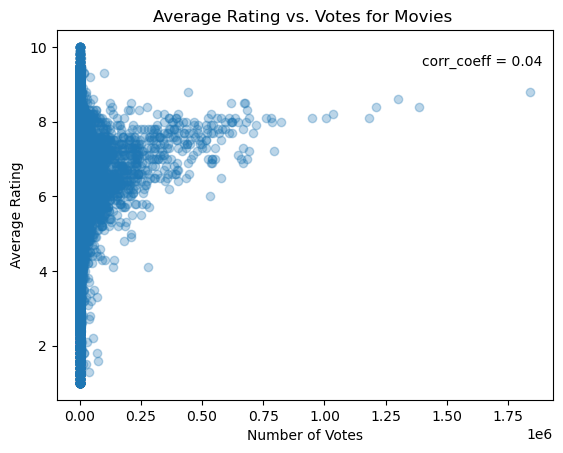

In [9]:
#Create a scatter plot to check correlation between variables
fig, ax = plt.subplots()
ax.scatter(x = imdb_basics_ratings['numvotes'], y = imdb_basics_ratings['avg_rating'], alpha = 0.3)
ax.set_title('Average Rating vs. Votes for Movies ')
ax.set_xlabel('Number of Votes')
ax.set_ylabel('Average Rating')
rho = 'corr_coeff = {:.2f}'.format(imdb_basics_ratings['avg_rating'].corr(imdb_basics_ratings['numvotes']))
ax.text(1.4*10**6,9.5,rho)
plt.savefig("./images/rating_votes_correlation.png", dpi = 150)
plt.show();

In [10]:
# Generate correlation matrix
imdb_basics_ratings[['avg_rating','numvotes']].corr()

,avg_rating,numvotes
avg_rating,1.000000,0.044478
numvotes,0.044478,1.000000


Next, I format the release date field of the budget data, creating a field "year" that can be used to merge the budget and movie data.  This is necessary because of the potential for movies with the same name to be released in different years.  The monetary amounts are also converted from strings to integers to compute the net domestic profits.

In [11]:
#Create a release year to assist merge with basic movie data
budget['date'] = pd.to_datetime(budget['release_date'])
budget['year'] = budget['date'].dt.year

# Budget data is formatted with a $.  Remove so can perform broadcasting to get net profits
budget['domestic_gross_int'] = budget['domestic_gross'].str.replace('\$|,','', regex = True).astype(int)
budget['production_budget_int'] = budget['production_budget'].str.replace('\$|,','', regex = True).astype(int)

budget['net_profit'] = budget['domestic_gross_int'] - budget['production_budget_int']

In [12]:
# Drop extra columns
local_profits = budget.drop(['id','release_date','domestic_gross','production_budget','worldwide_gross','date'], axis = 1)

local_profits = local_profits.sort_values('net_profit', ascending = False)
local_profits.shape   # 5782 rows

(5782, 5)

The net domestic profits information is then merged with the movie characteristics and rating information.  

In [13]:
#Inner join of movie characteristics and budget data
imdb_votesrates_budget = imdb_basics_ratings.merge(local_profits, left_on = ['primary_title','start_year'],\
                        right_on = ['movie','year'], how = 'inner')

imdb_votesrates_budget.shape  #1498 rows

(1498, 11)

In [14]:
imdb_votesrates_budget.describe()

,start_year,avg_rating,numvotes,year,domestic_gross_int,production_budget_int,net_profit
count,1498.000000,1498.000000,1.498000e+03,1498.000000,1.498000e+03,1.498000e+03,1.498000e+03
mean,2013.844459,6.288318,1.148142e+05,2013.844459,5.650938e+07,4.483078e+07,1.167860e+07
std,2.566518,1.071363,1.641172e+05,2.566518,8.491064e+07,5.622902e+07,5.959762e+07
min,2010.000000,1.600000,5.000000e+00,2010.000000,0.000000e+00,1.500000e+04,-3.072376e+08
25%,2012.000000,5.700000,1.405750e+04,2012.000000,3.243797e+06,8.000000e+06,-1.109683e+07
50%,2014.000000,6.400000,5.843150e+04,2014.000000,2.786025e+07,2.300000e+07,-3.000000e+05
75%,2016.000000,7.000000,1.405365e+05,2016.000000,6.756418e+07,5.500000e+07,2.259768e+07
max,2019.000000,8.800000,1.841066e+06,2019.000000,7.000596e+08,4.106000e+08,5.000596e+08


The join leads to a significant loss of movie data and leaves a set wherein the measures of success are more cloely correlated.  While it is obvious that more votes cast is associated with more people contributing to the profits of the movie by buying tickets, these results also reflect that movies with high numbers of votes cast tended to receive higher ratings.

In [16]:
#Check correlation within the limited set of movies
imdb_votesrates_budget
imdb_votesrates_budget[['avg_rating','numvotes','net_profit']].corr()

,avg_rating,numvotes,net_profit
avg_rating,1.000000,0.481304,0.244327
numvotes,0.481304,1.000000,0.432347
net_profit,0.244327,0.432347,1.000000


The next step is to truncate the dataset to those movies that received above average profits, votes, and ratings. This will create the set of movies deemed most successful on which I will perform the analysis to find the most successful genre of film, the director most likely to support that genre of film's production, and the most successful director overall.

In [17]:
# Further subset data to movies with above average values for all three success criteria
avg_profit = imdb_votesrates_budget['net_profit'].mean()
avg_votes = imdb_votesrates_budget['numvotes'].mean()
avg_ratings = imdb_votesrates_budget['avg_rating'].mean()

imdb_votesrates_budget_trunc = \
                    imdb_votesrates_budget[(imdb_votesrates_budget['net_profit'] > avg_profit) &\
                                           (imdb_votesrates_budget['avg_rating'] > avg_ratings) &\
                                           (imdb_votesrates_budget['numvotes'] > avg_votes)]

imdb_votesrates_budget_trunc.sort_values('numvotes', ascending = False)

,movie_id,primary_title,start_year,genres,avg_rating,numvotes,movie,year,domestic_gross_int,production_budget_int,net_profit
0,tt1375666,Inception,2010,"Action,Adventure,Sci-Fi",8.8,1841066,Inception,2010,292576195,160000000,132576195
7,tt1345836,The Dark Knight Rises,2012,"Action,Thriller",8.4,1387769,The Dark Knight Rises,2012,448139099,275000000,173139099
3,tt0816692,Interstellar,2014,"Adventure,Drama,Sci-Fi",8.6,1299334,Interstellar,2014,188017894,165000000,23017894
9,tt1853728,Django Unchained,2012,"Drama,Western",8.4,1211405,Django Unchained,2012,162805434,100000000,62805434
27,tt0848228,The Avengers,2012,"Action,Adventure,Sci-Fi",8.1,1183655,The Avengers,2012,623279547,225000000,398279547
...,...,...,...,...,...,...,...,...,...,...,...
730,tt0815236,She's Out of My League,2010,"Comedy,Romance",6.4,117245,She's Out of My League,2010,32010860,20000000,12010860
180,tt2381111,Brooklyn,2015,"Drama,Romance",7.5,117021,Brooklyn,2015,38322743,11000000,27322743
269,tt4116284,The Lego Batman Movie,2017,"Action,Animation,Comedy",7.3,116433,The Lego Batman Movie,2017,175750384,80000000,95750384
154,tt5083738,The Favourite,2018,"Biography,Drama,History",7.6,116011,The Favourite,2018,34366783,15000000,19366783


The last step is to build a dataset that combines the principal and persons data tables.  This will allow me to match the sets of movies to the directors responsible for them.

In [18]:
directors =pd.read_sql("""SELECT movie_id, ordering, person_id, primary_name
                            FROM principals
                           INNER JOIN persons
                                 USING (person_id)
                           WHERE category = 'director'
                           ORDER BY movie_id, ordering;
                        """, conn)
directors.head()

,movie_id,ordering,person_id,primary_name
0,tt0063540,5,nm0712540,Harnam Singh Rawail
1,tt0066787,5,nm0002411,Mani Kaul
2,tt0069049,5,nm0000080,Orson Welles
3,tt0069204,5,nm0611531,Hrishikesh Mukherjee
4,tt0100275,5,nm0749914,Raoul Ruiz


In [19]:
# Merge in director information with the current set of successful movies 
imdb_trunc_directors = imdb_votesrates_budget_trunc.merge(directors, on = 'movie_id', how = 'left')

imdb_trunc_directors_wbudget = imdb_trunc_directors.drop(['year','domestic_gross_int'], axis = 1)
imdb_trunc_directors.drop(['year','domestic_gross_int','production_budget_int'], axis = 1, inplace = True)

imdb_trunc_directors.sort_values(['movie_id','ordering'], inplace = True)
imdb_trunc_directors.head()

,movie_id,primary_title,start_year,genres,avg_rating,numvotes,movie,net_profit,ordering,person_id,primary_name
185,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,539338,Jurassic World,437270625,5.0,nm1119880,Colin Trevorrow
8,tt0435761,Toy Story 3,2010,"Adventure,Animation,Comedy",8.3,682218,Toy Story 3,215004880,5.0,nm0881279,Lee Unkrich
118,tt0443272,Lincoln,2012,"Biography,Drama,History",7.4,228701,Lincoln,117207973,5.0,nm0000229,Steven Spielberg
229,tt0448694,Puss in Boots,2011,"Action,Adventure,Animation",6.6,133355,Puss in Boots,19260504,5.0,nm3735491,Chris Miller
103,tt0451279,Wonder Woman,2017,"Action,Adventure,Fantasy",7.5,487527,Wonder Woman,262563408,5.0,nm0420941,Patty Jenkins


Because many movies have more than one director, I focus the analysis on the principle director who is assumed to have the lower "ordering" number in the principals table.

In [20]:
# Assume the director with the lower "ordering" number is the principal in charge of the movie.  
imdb_trunc_directors[imdb_trunc_directors['movie_id'].duplicated()]
imdb_trunc_directors.drop_duplicates(subset=['movie_id'], keep = 'first', inplace = True)

## Data Modeling

### Identify the most frequently cited genres within the set of successful movies.

To do this, I aggregate the results by genre and try to optimize over 2 or more of the factors of popularity, quality, and net domestic profit.  Because some films feature more than one genre code, I assume that it is the first genre listed that is most representative of the film.  The distribution of films by genre is printed below.

In [21]:
# Maing use of Assumption 4: Split off first mention within genre category to stand on its own in separate column.
imdb_votesrates_budget_trunc['first_genre'] = \
                            imdb_votesrates_budget_trunc['genres'].map(lambda x: x.split(',')[0] \
                                                                        if x !=None else None)

imdb_votesrates_budget_trunc['first_genre'].value_counts()

C:\Users\jacqu\AppData\Local\Temp\ipykernel_6684\704316776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_votesrates_budget_trunc['first_genre'] = \


Action       98
Comedy       32
Adventure    30
Drama        30
Biography    26
Crime        12
Horror        4
Mystery       3
Animation     3
Family        1
Romance       1
Fantasy       1
Name: first_genre, dtype: int64

In [22]:
# Compute aggregates for the ratings, number of votes, and net profit by genre
aggregate_dict = {'avg_rating':'mean','numvotes':'mean','net_profit':'mean'}
imdb_genre_score = imdb_votesrates_budget_trunc.groupby('first_genre').agg(aggregate_dict)

print(imdb_genre_score.mean())
print(imdb_genre_score.corr())
imdb_genre_score.sort_values('avg_rating', ascending = False)

avg_rating    7.263464e+00
numvotes      3.216162e+05
net_profit    9.983850e+07
dtype: float64
            avg_rating  numvotes  net_profit
avg_rating    1.000000  0.606230    0.048291
numvotes      0.606230  1.000000   -0.113402
net_profit    0.048291 -0.113402    1.000000


,avg_rating,numvotes,net_profit
first_genre,,,
Biography,7.761538,320035.653846,6.010731e+07
Crime,7.525000,364047.583333,3.694070e+07
Mystery,7.500000,606341.666667,5.908886e+07
Drama,7.410000,306217.233333,6.396078e+07
Horror,7.350000,338793.750000,1.565024e+08
Adventure,7.333333,367649.533333,1.139780e+08
Animation,7.300000,261677.666667,1.470520e+08
Action,7.228571,422233.224490,1.063524e+08
Family,7.200000,238325.000000,3.440142e+08


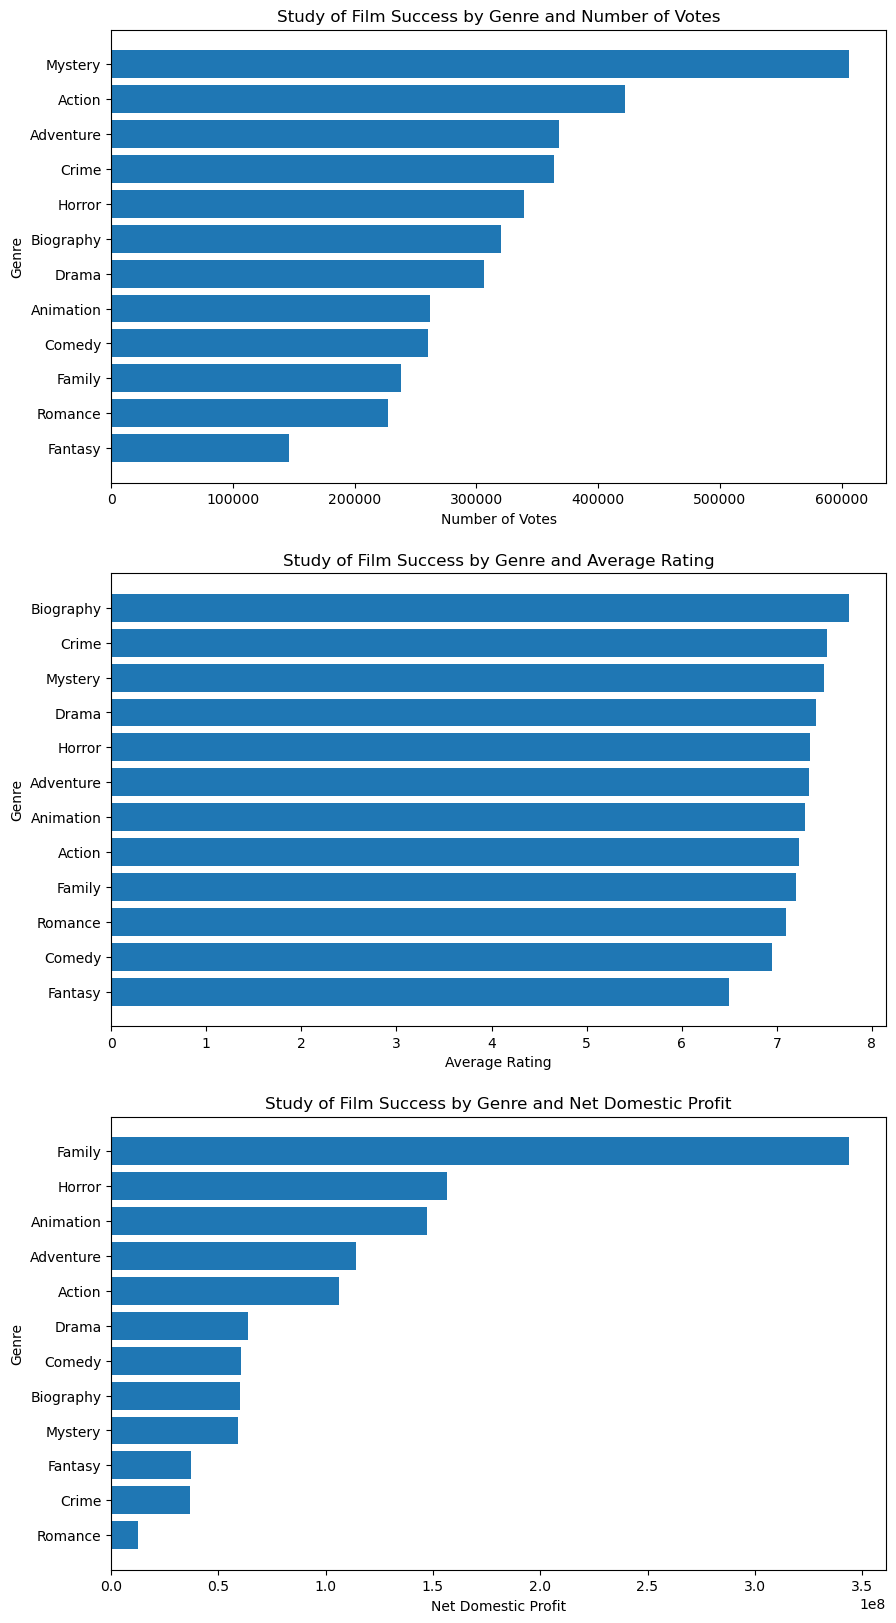

In [23]:
#Generate plot of genres by success categories while simultaneously creating lists of the top three genres
#registering as successful among each of the three sucess categories.

imdb_genre_score = imdb_genre_score.reset_index()

fig, (ax1,ax2,ax3) = plt.subplots(nrows = 3,ncols =1, figsize = (10,20))

imdb_genre_score.sort_values('numvotes', inplace = True)
top_threegenres_1 = imdb_genre_score.iloc[-3:]['first_genre']
top_fourgenres_1 = imdb_genre_score.iloc[-4:]['first_genre']
ax1.barh(y = imdb_genre_score['first_genre'], width = imdb_genre_score['numvotes'])

imdb_genre_score.sort_values('avg_rating', inplace = True)
top_threegenres_2 = imdb_genre_score.iloc[-3:]['first_genre']
top_fourgenres_2 = imdb_genre_score.iloc[-4:]['first_genre']
ax2.barh(y = imdb_genre_score['first_genre'], width = imdb_genre_score['avg_rating'])

imdb_genre_score.sort_values('net_profit', inplace = True)
top_threegenres_3 = imdb_genre_score.iloc[-3:]['first_genre']
top_fourgenres_3 = imdb_genre_score.iloc[-4:]['first_genre']
ax3.barh(y = imdb_genre_score['first_genre'], width = imdb_genre_score['net_profit']);

ax1.set_ylabel('Genre')
ax1.set_xlabel('Number of Votes')
ax1.set_title('Study of Film Success by Genre and Number of Votes')

ax2.set_ylabel('Genre')
ax2.set_xlabel('Average Rating')
ax2.set_title('Study of Film Success by Genre and Average Rating')

ax3.set_ylabel('Genre')
ax3.set_xlabel('Net Domestic Profit')
ax3.set_title('Study of Film Success by Genre and Net Domestic Profit')

plt.savefig("./images/genre_success_factor.png", dpi = 150)
plt.show();


In [24]:
value_threecounts_genre = pd.concat([top_threegenres_1,top_threegenres_2,top_threegenres_3]).value_counts()
top_threegenres_overall_vc = value_threecounts_genre[value_threecounts_genre >= 2]
top_threegenres_overall_names = top_threegenres_overall_vc.index
print(f"Top genre among top three selected from each success category: {top_threegenres_overall_names}")

value_fourcounts_genre = pd.concat([top_fourgenres_1,top_fourgenres_2,top_fourgenres_3]).value_counts()
top_fourgenres_overall_vc = value_fourcounts_genre[value_fourcounts_genre >= 2]
top_fourgenres_overall_names = top_fourgenres_overall_vc.index
print(f"Top genre among top four selected from each success category: {top_fourgenres_overall_names}")


Top genre among top three selected from each success category: Index(['Mystery'], dtype='object')
Top genre among top four selected from each success category: Index(['Crime', 'Adventure', 'Mystery'], dtype='object')


The smallest set of genres (3) that maximizes at least two of the categories correlated with success reveals that the Mystery genre may be a place to start. Widening the set to four, I find three genres that optimize at least two of the categories: Mystery, Advernture, and Crime.  The average budget for a film of these genres is approximately \\$132,000,000 for an Adventure film, \\$52,300,000  for a Mystery film, and \\$40,300,000 for a Crime film.

In [25]:
aggregate_dict = {'production_budget_int': ['mean','std']}
production_genre_aggregate = imdb_votesrates_budget_trunc.groupby('first_genre').agg(aggregate_dict)
production_genre_aggregate.sort_values([('production_budget_int','mean')], ascending = False)

production_budget_int              
                             mean           std
first_genre                                    
Family               1.600000e+08           NaN
Adventure            1.318167e+08  6.545444e+07
Action               1.189908e+08  7.208563e+07
Animation            7.633333e+07  8.082904e+06
Mystery              5.233333e+07  2.657693e+07
Romance              5.020000e+07           NaN
Crime                4.029167e+07  2.490022e+07
Biography            3.640385e+07  2.444423e+07
Drama                3.028333e+07  2.826253e+07
Comedy               2.900000e+07  1.858763e+07
Fantasy              1.700000e+07           NaN
Horror               1.575000e+07  1.490805e+07

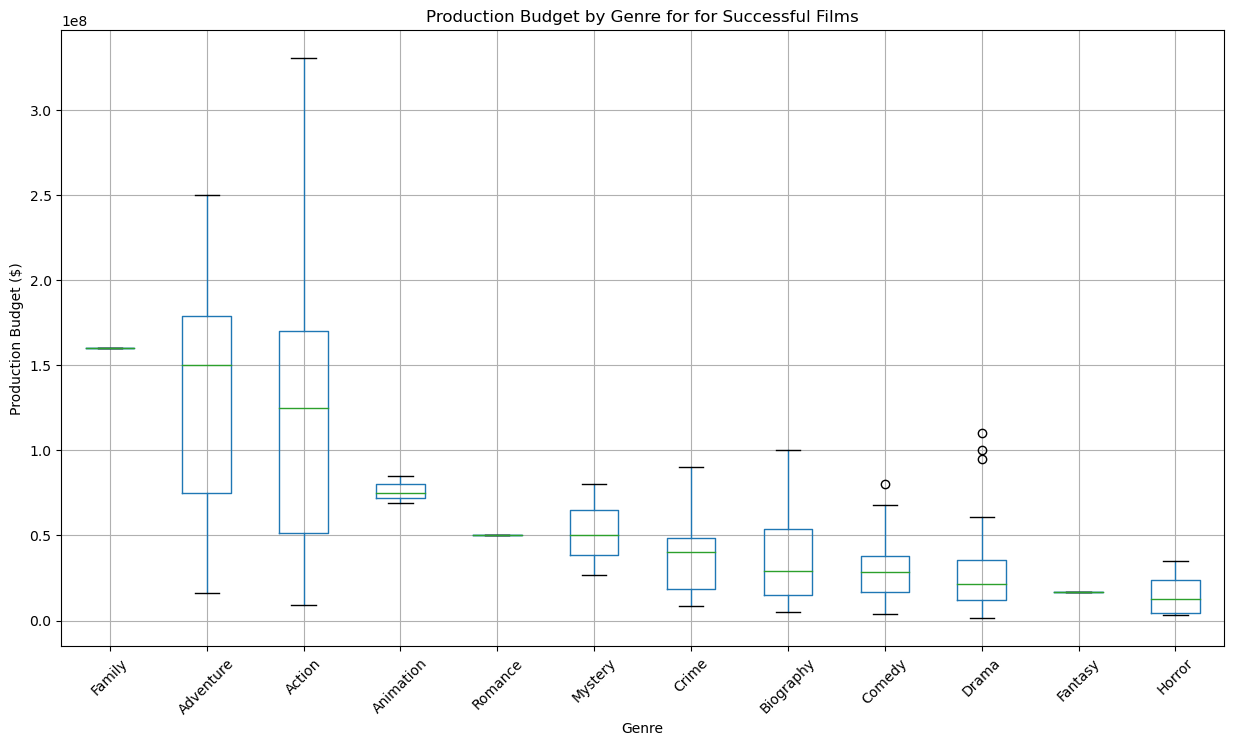

In [26]:
#Boxplot sorting function from https://medium.com/the-barometer/note-to-self-pandas-sort-boxplots-by-median-2a6c70c11644
def boxplot_sorted(df, by, column, rot = 45):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values(ascending = False)
    return df2[meds.index].boxplot(rot = rot, return_type = "axes", figsize = (15,8))



axes = boxplot_sorted(imdb_votesrates_budget_trunc, by = ['first_genre'], column = 'production_budget_int')
plt.xlabel('Genre')
plt.ylabel('Production Budget ($)')
#plt.yticks(np.arange(11))
plt.title('Production Budget by Genre for for Successful Films')
plt.savefig("./images/genre_budget.png", dpi = 150)
plt.show();


### Directors associated with the most successful films' genres

I assert that the more of these films a director has been involved in, the more knowledgeable that person is of the components required to make a successful film. I determine which directors to select based on those represented in the top half of the histogram representing the count of films any given director has produced. 


In [27]:
# Produce the value counts of films per director in order to find those directors who produced the most films
# among the list of successful movies

top_directors_vc = imdb_trunc_directors['primary_name'].value_counts()

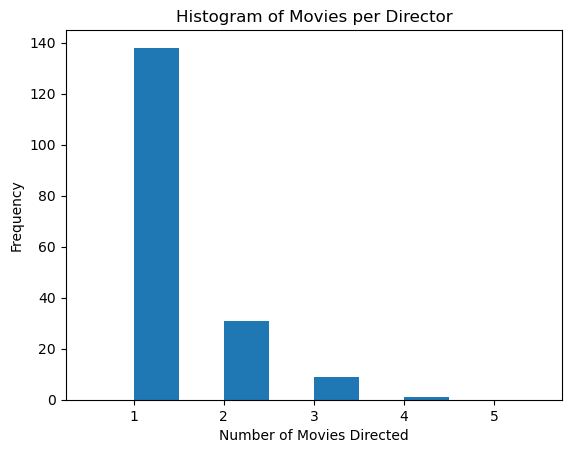

In [28]:
# Select the directors represented by the top half of the histogram
fig, ax = plt.subplots()
ax.hist(top_directors_vc, range = [0.5,5.5])
ax.set_title('Histogram of Movies per Director')
ax.set_xlabel('Number of Movies Directed')
ax.set_ylabel('Frequency')
plt.savefig("./images/director_histogram", dpi = 150)
plt.show();

In [29]:
# Find number of directors making up the top half of the histogram
histpatches = ax.patches
count_half = int(len(histpatches)/2)
freq = [patch.get_height() for patch in histpatches]
top_count = int(sum(freq[-count_half:]))
print(top_count)

# Names of directors making up the top half of the histogram
top_directors_names = top_directors_vc[0:top_count].index 
print(top_directors_names)

10
Index(['Christopher Nolan', 'Adam McKay', 'Phil Lord', 'Francis Lawrence',
       'James Wan', 'Anthony Russo', 'David O. Russell', 'David Fincher',
       'Antoine Fuqua', 'Denis Villeneuve'],
      dtype='object')


In [30]:
imdb_trunc_directors

,movie_id,primary_title,start_year,genres,avg_rating,numvotes,movie,net_profit,ordering,person_id,primary_name
185,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,539338,Jurassic World,437270625,5.0,nm1119880,Colin Trevorrow
8,tt0435761,Toy Story 3,2010,"Adventure,Animation,Comedy",8.3,682218,Toy Story 3,215004880,5.0,nm0881279,Lee Unkrich
118,tt0443272,Lincoln,2012,"Biography,Drama,History",7.4,228701,Lincoln,117207973,5.0,nm0000229,Steven Spielberg
229,tt0448694,Puss in Boots,2011,"Action,Adventure,Animation",6.6,133355,Puss in Boots,19260504,5.0,nm3735491,Chris Miller
103,tt0451279,Wonder Woman,2017,"Action,Adventure,Fantasy",7.5,487527,Wonder Woman,262563408,5.0,nm0420941,Patty Jenkins
...,...,...,...,...,...,...,...,...,...,...,...
102,tt6644200,A Quiet Place,2018,"Drama,Horror,Sci-Fi",7.6,305031,A Quiet Place,171024361,NaN,NaN,NaN
221,tt6823368,Glass,2019,"Drama,Sci-Fi,Thriller",6.8,133793,Glass,91035005,5.0,nm0796117,M. Night Shyamalan
9,tt6966692,Green Book,2018,"Biography,Comedy,Drama",8.3,204972,Green Book,62080171,5.0,nm0268380,Peter Farrelly
117,tt7349662,BlacKkKlansman,2018,"Biography,Crime,Drama",7.5,149005,BlacKkKlansman,34275340,5.0,nm0000490,Spike Lee


In [31]:
# The list of directors with movies in the selected genres and producing the most successful movies
imdb_trunc_directors['first_genre'] = \
                            imdb_trunc_directors['genres'].map(lambda x: x.split(',')[0] if x !=None else None)

imdb_trunc_directors[(imdb_trunc_directors['first_genre'].isin(list(top_fourgenres_overall_names))) & \
                     (imdb_trunc_directors['primary_name'].isin(top_directors_names))]

,movie_id,primary_title,start_year,genres,avg_rating,numvotes,movie,net_profit,ordering,person_id,primary_name,first_genre
1,tt0816692,Interstellar,2014,"Adventure,Drama,Sci-Fi",8.6,1299334,Interstellar,23017894,5.0,nm0634240,Christopher Nolan,Adventure
18,tt1392214,Prisoners,2013,"Crime,Drama,Mystery",8.1,526273,Prisoners,15002302,5.0,nm0898288,Denis Villeneuve,Crime
54,tt1568346,The Girl with the Dragon Tattoo,2011,"Crime,Drama,Mystery",7.8,387580,The Girl with the Dragon Tattoo,12515793,5.0,nm0000399,David Fincher,Crime
164,tt1800241,American Hustle,2013,"Crime,Drama",7.2,418221,American Hustle,110117807,5.0,nm0751102,David O. Russell,Crime


According to this analysis, there are four directors to consider. To produce an Adventure film, the company should consider Christopher Nolan.  If they wish to generate a Crime or Mystery the company can select from among David O. Russell, Denis Villeneuve, and David Fincher.

### Most successful directors overall

The most successful directors overall will be assessed on how well on average their movies performed according to the metrics of number of votes, average rating, and net domestic profits.  Top directors are defined as those producing more than 2 movies among those in the list of successful movies (representing the top half of the histogram).

In [32]:
# Isolate the directors to those who appeared in the top director list from the previous analysis
imdb_trunc_top_directors = imdb_trunc_directors[imdb_trunc_directors['primary_name'].isin(top_directors_names)]

# Carry over only necessary columns
imdb_cut_top_directors = imdb_trunc_top_directors[['primary_name','avg_rating','numvotes','net_profit']]

# Aggregate movies by director and sort
imdb_agg_top_directors = imdb_cut_top_directors.groupby('primary_name').mean()
imdb_agg_top_directors.sort_values('avg_rating',ascending = False, inplace = True)
imdb_agg_top_directors

,avg_rating,numvotes,net_profit
primary_name,,,
Christopher Nolan,8.425000,1.248687e+06,9.220037e+07
Anthony Russo,8.033333,6.402283e+05,2.088823e+08
David Fincher,7.866667,5.725833e+05,5.874856e+07
Denis Villeneuve,7.866667,4.567680e+05,2.847924e+07
David O. Russell,7.566667,4.519260e+05,1.012759e+08
Phil Lord,7.333333,3.671513e+05,1.453172e+08
James Wan,7.266667,3.318783e+05,1.518230e+08
Antoine Fuqua,7.033333,2.458427e+05,3.262676e+07
Adam McKay,6.933333,2.290023e+05,4.627752e+07


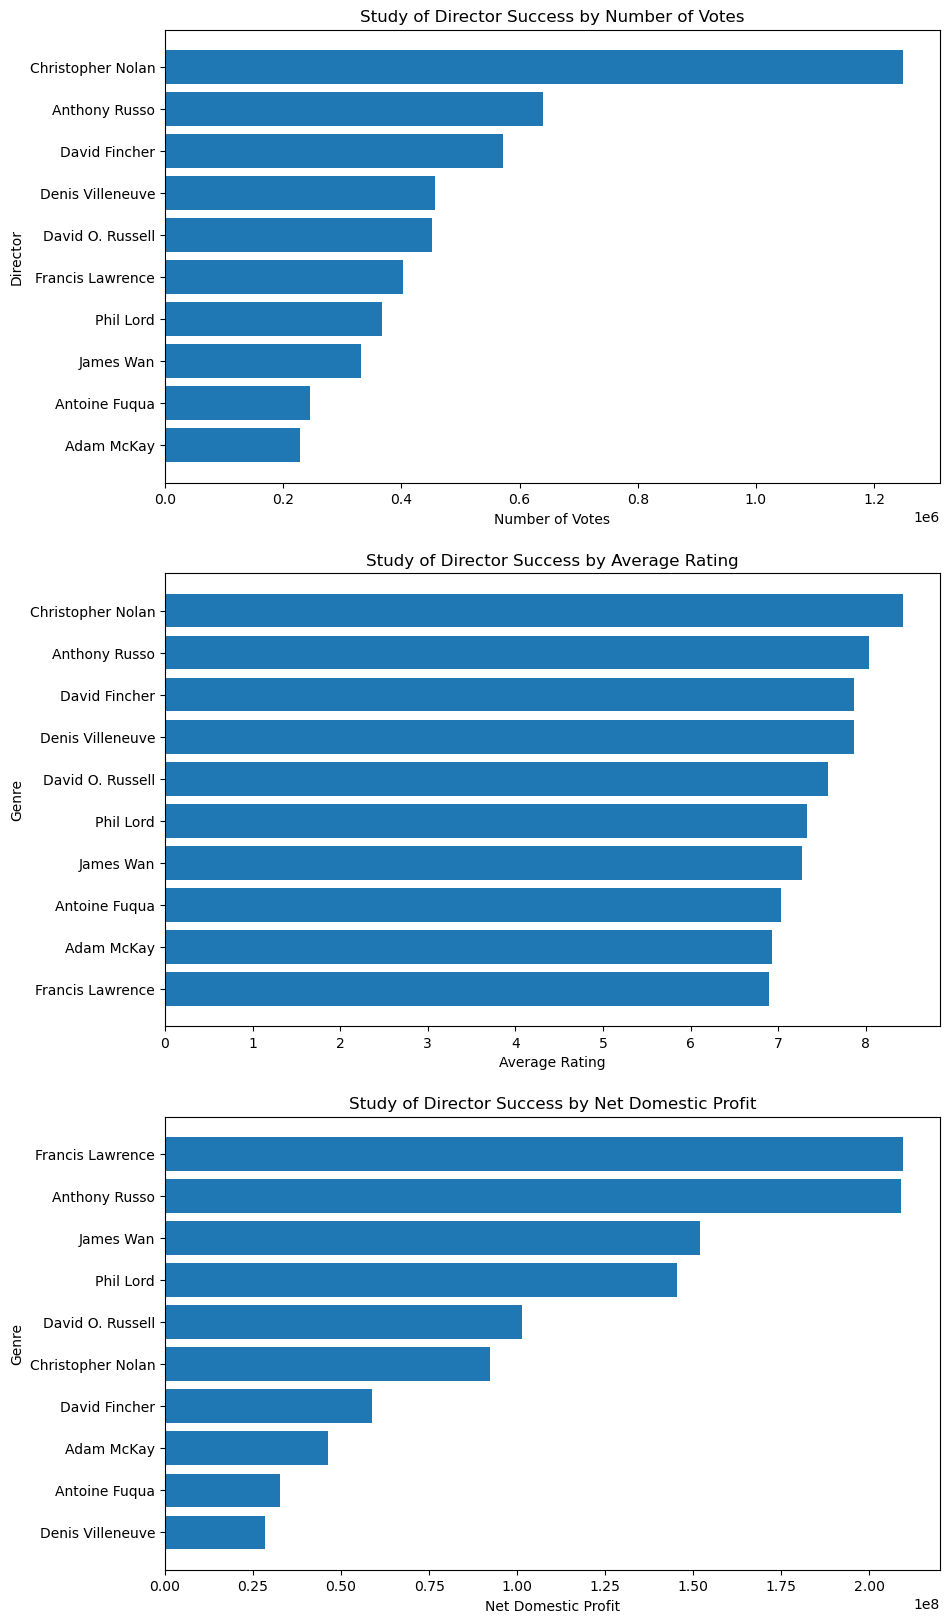

In [33]:
imdb_agg_top_directors = imdb_agg_top_directors.reset_index()

fig, (ax1,ax2,ax3) = plt.subplots(nrows = 3,ncols =1, figsize = (10,20))

imdb_agg_top_directors.sort_values('numvotes', inplace = True)
top_three1 = imdb_agg_top_directors.iloc[-3:]['primary_name']
ax1.barh(y = imdb_agg_top_directors['primary_name'], width = imdb_agg_top_directors['numvotes'])

imdb_agg_top_directors.sort_values('avg_rating', inplace = True)
top_three2 = imdb_agg_top_directors.iloc[-3:]['primary_name']
ax2.barh(y = imdb_agg_top_directors['primary_name'], width = imdb_agg_top_directors['avg_rating'])

imdb_agg_top_directors.sort_values('net_profit', inplace = True)
top_three3 = imdb_agg_top_directors.iloc[-3:]['primary_name']
ax3.barh(y = imdb_agg_top_directors['primary_name'], width = imdb_agg_top_directors['net_profit']);

ax1.set_ylabel('Director')
ax1.set_xlabel('Number of Votes')
ax1.set_title('Study of Director Success by Number of Votes')

ax2.set_ylabel('Genre')
ax2.set_xlabel('Average Rating')
ax2.set_title('Study of Director Success by Average Rating')

ax3.set_ylabel('Genre')
ax3.set_xlabel('Net Domestic Profit')
ax3.set_title('Study of Director Success by Net Domestic Profit')

plt.savefig("./images/director_success.png", dpi = 150)
plt.show();

In [34]:
#Look at the top three directors with the highest valuation in eqch of the ratings, number of votes, and net profits categories 
value_counts_directors = pd.concat([top_three1,top_three2,top_three3]).value_counts()

#Select directors corresponding to the top portion of the list, rounding up if necessary 
num_directors = np.ceil(len(value_counts_directors)/2)
top_directors_overall_vc = value_counts_directors.head(int(num_directors))
print(top_directors_overall_vc)

top_directors_overall_names = top_directors_overall_vc.index


Anthony Russo        3
David Fincher        2
Christopher Nolan    2
Name: primary_name, dtype: int64


In [35]:
def director_output(dataframe, names):
    
    """This function takes the database of films + directors and the list of the top 
        overall directors and generates their portfolio of movies as a function of
        genre and the success criteria.  This is to assess the diversity of
        their work."""
    
    for director in names:
        columns = ['movie','numvotes','avg_rating','net_profit','genres']
        output = dataframe.loc[dataframe['primary_name']==director,columns]
        print(director, '\n',pd.DataFrame(output).to_string(justify = 'center'), '\n')
    return()
           
director_output(imdb_trunc_directors, top_directors_overall_names)

Anthony Russo 
                   movie                  numvotes  avg_rating  net_profit          genres         
58  Captain America: The Winter Soldier   666252       7.8       89746958  Action,Adventure,Sci-Fi
62           Captain America: Civil War   583507       7.8      158084349  Action,Adventure,Sci-Fi
2                Avengers: Infinity War   670926       8.5      378815482  Action,Adventure,Sci-Fi 

David Fincher 
                 movie                numvotes  avg_rating  net_profit          genres        
70               The Social Network   568578       7.7       56962694         Biography,Drama
54  The Girl with the Dragon Tattoo   387580       7.8       12515793     Crime,Drama,Mystery
24                        Gone Girl   761592       8.1      106767189  Drama,Mystery,Thriller 

Christopher Nolan 
            movie           numvotes  avg_rating  net_profit          genres         
1            Interstellar   1299334      8.6       23017894   Adventure,Drama,Sci-Fi
4 

()

## Evaluation
The first step of the analysis was to determine the factors of success.  I used the nominally independent measures provded: Number of Votes (popularity), Average Rating (quality), and Domestic Net Profit (local financial success) to identify a set of "successful" movies. 

The analysis used to answer the first question revealed three genres, namely Mystery, Adventure, and Crime.  Additional analysis however, revealed an Adventure film's budget could be as high as \\$200 million which is 4 - 5 times greater than films in the other two genres.  This type of expense may pose a risk to Microsoft should the company's first venture yield a smaller than expected profit. 

The response to the second question pivoted on finding the smallest set of directors with which to work.  While it would have been appropriate to include directors who produced more than median number of films (1 film), doing so would have required additional criteria (e.g. awards) to subset the list to a size Microsoft could easily choose from.  Instead, I limited the starting set of directors to those that made up the top half of the histogram and were capable of producing films in the genres surfaced in the analysis that preceded.  This analysis suggested Christopher Nolan (highest rating, highest votes), David O'Russell (highest net profit), David Fincher, and David Villeneuve as possible candidates.  

Finally, the third question reveals a result that is fairly generalizable -- looking at the top producing directors among the successful films and reviewing their portfolios for measures of success and expressions of diversity of genres.  This analysis showed that director Anthony Russo, though successful, has gained reknown for a single type of film -- Action, Adventure, Sci-Fi films -- which may limit the demographic to which Microsoft may wish to appeal and incur financial risk given the large production cost of Action, Adventure films.

## Conclusion

This analysis leads to the following three recommendations to support Microsoft's foray into original video content:

If Microsoft decides to approach the venture by focusing on successful film genres, then it is recommended they --

> **Focus on genres associated with the most successful movies and moderate financial risk.**  Doing so will limit the broad option space to Mysery and Crime genres.

> **Hire the director most capable of realizing the genres associated with the most successful movies.**  This limits the field of directors to Denis Villeneuve, David Fincher, and David O. Russell.  Christopher Nolan would also be a candidate should the company wish to produce an Adventure film.

If Microsoft prefers to hire the most adept director and work with him to define the scope of the film, it is recommended they --

> **Hire the director that offers the greatest diversity of skill.**  This would suggest they consider David Fincher or Christopher Nolan.

## Limitations

Limitations of this approach stem from not using all of the listed genres in the analysis.  Only the first was used to avoid the complication of double or triple counting the factors pertaining to success.

## Future Work

Additional work in this area could include looking at how the presence of different actors affects the different measures of success of a given movie.  Likewise,  a more rigorous look at the production budget of different film genres or the financial implications of hiring certain actors could help inform Microsoft's venture